In [1]:
import numpy as np
from numpy import linalg as la
import networkx as nx
import matplotlib.pyplot as plt
import time

from sklearn.covariance import graphical_lasso

import opt
import utils

SEED = 10
np.random.seed(SEED)

In [2]:
# Functions
def norm_fro_err(A_hat, A_true):
    N = A_true.shape[0]
    A_true = A_true[~np.eye(N, dtype=bool)]
    A_hat = A_hat[~np.eye(N, dtype=bool)]
    A_true_n = A_true/la.norm(A_true)
    A_hat_n = A_hat/la.norm(A_hat)
    return la.norm(A_hat_n - A_true_n)


Shape of X: (100, 1000)


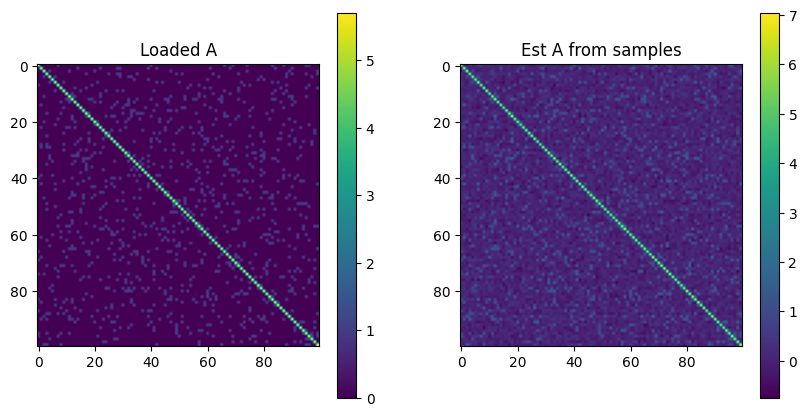

In [3]:
# Experiment parameters
N = 100
p = .1
M = 1000

# Create Graph
graph = nx.erdos_renyi_graph(N, p, directed=False)
A = nx.to_numpy_array(graph)

# Precision matrix as loaded adjacency
max_eigenval = np.abs(la.eigvalsh(A)[0])
# A_loaded = (max_eigenval + .01) * np.eye(N) + A
A_loaded = (max_eigenval + .05) * np.eye(N) + A
assert np.all(la.eigvalsh(A_loaded) >= 0), 'Precision is not a PSD matrix'

# Create GMRF signals
mean = np.zeros(N)
Cov = la.inv(A_loaded)
X = np.random.multivariate_normal(mean, Cov, size=M).T
Cov_hat = X @ X.T / M

# Create 2 sensitive groups
Z = np.zeros((2,N))
Z[0, 0:int(N/2)] = 1
Z[1, int(N/2):] = 1

# Plot data
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im1 = axes[0].imshow(A_loaded)
axes[0].set_title('Loaded A')
fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(la.inv(Cov_hat))
axes[1].set_title('Est A from samples')
fig.colorbar(im2, ax=axes[1])

print('Shape of X:', X.shape)

In [4]:
stepsize = .02
epsilon = .5
mu1 = np.log(N)/M * 10/5 #.01
mu2 = .1


#####   DP - FISTA estimate   #####
bias_type = 'dp'
t_i = time.time()
A_fista, errs_A_fista = opt.node_FGL_fista(Cov_hat, mu1, stepsize, mu2, Z, bias_type, epsilon=epsilon,
                                           iters=1000, A_true=A_loaded, prec_type='non-negative',
                                           EARLY_STOP=True)
t_solved = time.time() - t_i
print(f'FISTA solved in {t_solved:3f} secs')

#####   Nodewise - FISTA estimate   #####
bias_type = 'nodewise'
t_i = time.time()
A_fista_n, errs_A_fista_n = opt.node_FGL_fista(Cov_hat, mu1, stepsize, mu2, Z, bias_type, epsilon=epsilon,
                                           iters=1000, A_true=A_loaded, prec_type='non-negative', precomputed=True,
                                           EARLY_STOP=True)
t_solved = time.time() - t_i
print(f'FISTA nodewise solved in {t_solved:3f} secs')

#####   Graphical Lasso estimate   #####
t_i = time.time()
_, A_gl = graphical_lasso(Cov_hat, alpha=mu1, max_iter=1000, tol=1e-6)
t_solved = time.time() - t_i
print(f'GL solved in {t_solved:3f} secs')

FISTA solved in 5.031922 secs
FISTA nodewise solved in 3.614925 secs
GL solved in 11.973487 secs


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 1.944e-03
  warnings.warn(


Square fro err (naive): 0.285
Square fro err (FISTA): 0.031
Square fro err (FISTA Node): 0.031
Square fro err (GL): 0.051


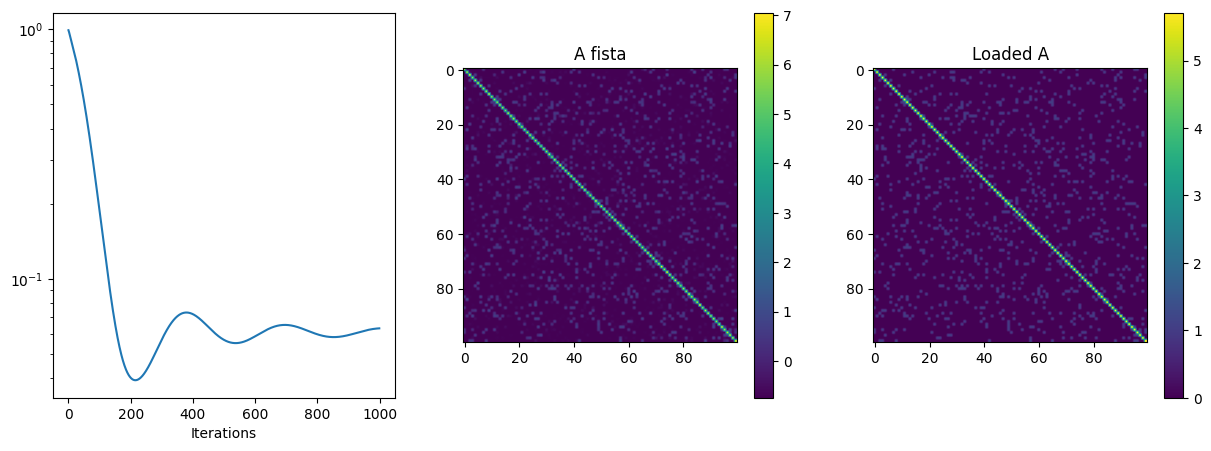

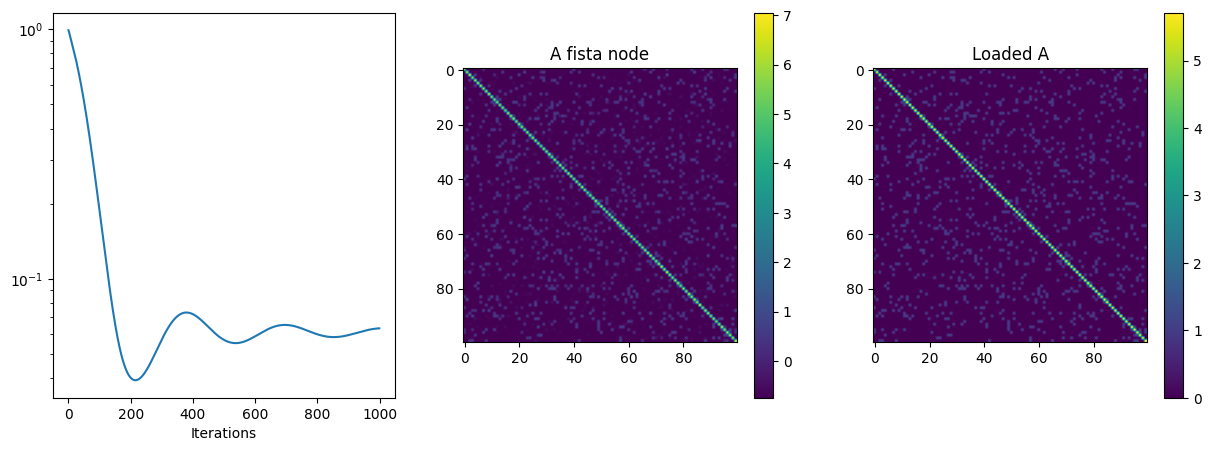

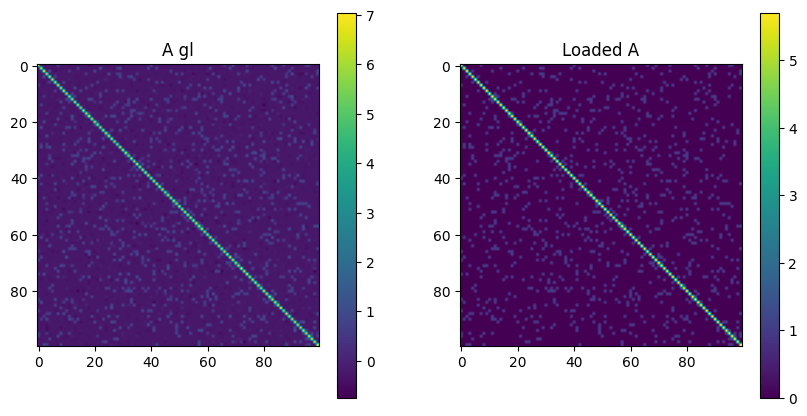

In [5]:
err_naive = norm_fro_err(la.inv(Cov_hat), A_loaded) **2
err_fista = norm_fro_err(A_fista, A_loaded) **2
err_fista_n = norm_fro_err(A_fista_n, A_loaded) **2
err_gl = norm_fro_err(A_gl, A_loaded) **2

print(f'Square fro err (naive): {err_naive:.3f}')
# print(f'Square fro err (PPGD)): {err_ppgd:.3f}')
print(f'Square fro err (FISTA): {err_fista:.3f}')
print(f'Square fro err (FISTA Node): {err_fista_n:.3f}')
print(f'Square fro err (GL): {err_gl:.3f}')


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im1 = axes[0].semilogy(errs_A_fista)
axes[0].set_xlabel('Err')
axes[0].set_xlabel('Iterations')
im = axes[1].imshow(A_fista)
axes[1].set_title('A fista')
fig.colorbar(im2, ax=axes[1])
im = axes[2].imshow(A_loaded)
axes[2].set_title('Loaded A')
fig.colorbar(im, ax=axes[2])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im1 = axes[0].semilogy(errs_A_fista_n)
axes[0].set_xlabel('Err')
axes[0].set_xlabel('Iterations')
im = axes[1].imshow(A_fista_n)
axes[1].set_title('A fista node')
fig.colorbar(im2, ax=axes[1])
im = axes[2].imshow(A_loaded)
axes[2].set_title('Loaded A')
fig.colorbar(im, ax=axes[2])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im = axes[0].imshow(A_gl)
axes[0].set_title('A gl')
fig.colorbar(im2, ax=axes[0])
im = axes[1].imshow(A_loaded)
axes[1].set_title('Loaded A')
fig.colorbar(im, ax=axes[1])
